# TensorFlow CNN training for Audio Classification
 ### - We recomend you read the comments in the code before running them all
 ### - It includes the code to train with 3 different datasets (ESC-50, FSDKaggle2018 and DatasetMix)
 ### - Keep in mind that each dataset requieres previous steps before it can be executed such as hashing the other datasets. 
 #  Remember to put the runtime in GPU

# Pre-processing Data 

In [1]:
# Mount the Drive to access files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Stablish path to were you have downloaded the files
root_path = '/content/drive/My Drive/ModeloKeras/'

In [0]:
# Import OS and direct our environment to the working directoey
import os
os.chdir(root_path)

In [0]:
# Load python libraries
%matplotlib inline
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import scale
import librosa.display
import librosa
import matplotlib.pyplot as plt

## Funcition Definition for Mel-Spectograms and Train - Test Split

In [0]:
# We create this function to later recall it to both calculate and save the Mel-Spectogram

def save_melspectrogram(directory_path, file_name, dataset_split, label, sampling_rate=44100):
    """ Will save spectogram into current directory"""
    
    path_to_file = os.path.join(directory_path, file_name)
    data, sr = librosa.load(path_to_file, sr=sampling_rate, mono=True)
    data = scale(data)

    melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    # Convert to log scale (dB) using the peak power (max) as reference
        # per suggestion from Librbosa: https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html
    log_melspec = librosa.power_to_db(melspec, ref=np.max)  
    librosa.display.specshow(log_melspec, sr=sr)
    
    # Create saving directory
    directory = './ESC-50-master/melspectrograms/{dataset}/{label}'.format(dataset=dataset_split, label=label)
    os.makedirs(directory, exist_ok=True)
    
    plt.savefig(directory + '/' + file_name.strip('.wav') + '.png')

In [0]:
# As we later use a concurrent task we define the seed that later will be use to split our data

def _train_test_split(filenames, train_pct):
    """Create train and test splits data"""
    random.seed(2018)
    n_files = len(filenames)
    n_train = int(n_files*train_pct)
    train = np.random.choice(n_files, n_train, replace=False)
        
    # split on training indices
    training_idx = np.isin(range(n_files), train)
    training_set = np.array(filenames)[training_idx]
    testing_set = np.array(filenames)[~training_idx]
    print('\tfiles in training set: {}, files in testing set: {}'.format(len(training_set), len(testing_set)))
    
    return {'training': training_set, 'testing': testing_set}

In [7]:
# View the different labels of the ESC-50 database

dataset_dir = './ESC-50-master'

# Load meta data for audio files
meta_data = pd.read_csv(dataset_dir + '/meta/esc50.csv')

labs = meta_data.category
unique_labels = labs.unique()
print(unique_labels)
meta_data.head()

['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
# View the different labels of FSDKaggle2018 database 
dataset_dir = './Kaggle_Dataset/sonidos - copia/'

# Load meta data for audio files
meta_data = pd.read_csv(dataset_dir + '/meta/metadata.csv')

labs = meta_data.label
unique_labels = labs.unique()
print(unique_labels)
meta_data.head()

['Hi-hat' 'Saxophone' 'Trumpet' 'Oboe' 'Glockenspiel' 'Cello' 'Bass_drum'
 'Knock' 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard'
 'Keys_jangling' 'Snare_drum' 'Writing' 'Laughter' 'Chime' 'Tearing'
 'Fart' 'Flute' 'Cough' 'Telephone' 'Bark' 'Electric_piano' 'Shatter'
 'Bus' 'Squeak' 'Scissors' 'Harmonica' 'Gong' 'Microwave_oven'
 'Burping_or_eructation' 'Double_bass' 'Fireworks' 'Tambourine'
 'Acoustic_guitar' 'Cowbell' 'Meow' 'Drawer_open_or_close'
 'Violin_or_fiddle' 'Applause' 'Finger_snapping']


,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,00326aa9.wav,Oboe,Private,355125,Attribution
4,0033e230.wav,Glockenspiel,1,325017,Attribution


In [7]:
# View the different labels of the DatasetMix Database
dataset_dir = '/content/drive/My Drive/DataProject 4/4.Audio/Dataset_Mix/'

# Load meta data for audio files
meta_data = pd.read_csv(dataset_dir + '/meta/metadata.csv')

meta_data2 = pd.read_csv(dataset_dir + '/meta/metadata.csv')

labs = meta_data.label
unique_labels = labs.unique()
print(unique_labels)
meta_data.head()

['Hi-hat' 'Saxophone' 'Trumpet' 'Oboe' 'Glockenspiel' 'Cello' 'Bass_drum'
 'Knock' 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard'
 'Keys_jangling' 'Snare_drum' 'Writing' 'Laughter' 'Chime' 'Tearing'
 'Fart' 'Flute' 'Cough' 'Telephone' 'Bark' 'Electric_piano' 'Shatter'
 'Bus' 'Squeak' 'Scissors' 'Harmonica' 'Gong' 'Microwave_oven'
 'Burping_or_eructation' 'Double_bass' 'Fireworks' 'Tambourine'
 'Acoustic_guitar' 'Cowbell' 'Meow' 'Drawer_open_or_close'
 'Violin_or_fiddle' 'Applause' 'Finger_snapping']


,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,00326aa9.wav,Oboe,Private,355125,Attribution
4,0033e230.wav,Glockenspiel,1,325017,Attribution


In [0]:
# Selection of interesting sounds from the database for our train/test split the first one is for ESC-50 the second for FSDKaggle2018
interesting_sounds = ['dog','cat','pouring_water','toilet_flush','crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping','door_wood_knock','can_opening','glass_breaking']
#interesting_sounds = ['Knock', 'Computer_keyboard', 'Cough', 'Laughter', 'Fart', 'Telephone', 'Bark', 'Burping_or_eructation', 'Meow', 'Applause', 'Finger_snapping', 'Shatter', 'Drawer_open_or_close']

In [9]:
# Concurrent for paralelysing the task of splitting the data and creating the mel spectograms
import concurrent
from tqdm import tqdm

def compute_and_save_mel_spectogram(data):
    directory_path, filename, dataset_split, label = data
    save_melspectrogram(directory_path, filename, dataset_split, label, sampling_rate=44100)
    return filename

results = []

for label in interesting_sounds:
    print('\nProccesing {} audio files'.format(label))
    current_label_meta_data = meta_data[meta_data.category == label]
    datasets = _train_test_split(current_label_meta_data.filename, train_pct=0.8)
    for dataset_split, audio_files in datasets.items():
        n_audio_files = len(audio_files)
        directory_path = dataset_dir + '/audio/'
        data = list(zip([directory_path] * n_audio_files,  audio_files, [dataset_split] * n_audio_files, [label] * n_audio_files))
        
        # Create a pool of processes. By default, one is created for each CPU in your machine.
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # Process the list of files, but split the work across the process pool to use all CPUs!
            for out_fn in tqdm(executor.map(compute_and_save_mel_spectogram, data), total=len(data)):
                results.append(out_fn)
        


Proccesing dog audio files
	files in training set: 32, files in testing set: 8


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Proccesing cat audio files
	files in training set: 32, files in testing set: 8



 69%|██████▉   | 22/32 [00:27<00:12,  1.23s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 72%|███████▏  | 23/32 [00:29<00:12,  1.39s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 81%|████████▏ | 26/32 [00:33<00:09,  1.55s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered


Proccesing pouring_water audio files
	files in training set: 32, files in testing set: 8



 34%|███▍      | 11/32 [00:11<00:22,  1.07s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 25%|██▌       | 2/8 [00:02<00:10,  1.76s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Proccesing toilet_flush audio files
	files in training set: 32, files in testing set: 8



 59%|█████▉    | 19/32 [00:23<00:17,  1.36s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 69%|██████▉   | 22/32 [00:25<00:09,  1.07it/s]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 91%|█████████ | 29/32 [00:39<00:04,  1.65s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered


Proccesing crying_baby audio files
	files in training set: 32, files in testing set: 8



 19%|█▉        | 6/32 [00:07<00:34,  1.35s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 59%|█████▉    | 19/32 [00:21<00:14,  1.08s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Proccesing sneezing audio files
	files in training set: 32, files in testing set: 8



100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Proccesing clapping audio files
	files in training set: 32, files in testing set: 8



 69%|██████▉   | 22/32 [00:27<00:11,  1.13s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 94%|█████████▍| 30/32 [00:40<00:03,  1.58s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Proccesing breathing audio files
	files in training set: 32, files in testing set: 8



 16%|█▌        | 5/32 [00:07<00:54,  2.00s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 84%|████████▍ | 27/32 [00:35<00:05,  1.17s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Proccesing coughing audio files
	files in training set: 32, files in testing set: 8



 38%|███▊      | 3/8 [00:02<00:06,  1.36s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Proccesing footsteps audio files
	files in training set: 32, files in testing set: 8



 22%|██▏       | 7/32 [00:08<00:32,  1.32s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 38%|███▊      | 12/32 [00:12<00:18,  1.11it/s]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 53%|█████▎    | 17/32 [00:19<00:20,  1.34s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered 


Proccesing laughing audio files
	files in training set: 32, files in testing set: 8



 62%|██████▎   | 20/32 [00:23<00:13,  1.17s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Proccesing brushing_teeth audio files
	files in training set: 32, files in testing set: 8



 31%|███▏      | 10/32 [00:12<00:28,  1.27s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 50%|█████     | 16/32 [00:20<00:20,  1.28s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
 59%|█████▉    | 19/32 [00:23<00:12,  1.07it/s]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered


Proccesing snoring audio files
	files in training set: 32, files in testing set: 8



 16%|█▌        | 5/32 [00:06<00:47,  1.76s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Proccesing drinking_sipping audio files
	files in training set: 32, files in testing set: 8



 91%|█████████ | 29/32 [00:35<00:03,  1.12s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Proccesing door_wood_knock audio files
	files in training set: 32, files in testing set: 8



 88%|████████▊ | 7/8 [00:05<00:00,  1.15it/s]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Proccesing can_opening audio files
	files in training set: 32, files in testing set: 8



  3%|▎         | 1/32 [00:02<01:20,  2.61s/it]/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Proccesing glass_breaking audio files
	files in training set: 32, files in testing set: 8



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


In [7]:
# Check the result of the calculatiion of Spectrograms
!ls -lah ESC-50-master/melspectrograms/*/*

ESC-50-master/melspectrograms/testing/breathing:
total 563K
-rw------- 1 root root 23K Apr 21 12:25 1-36400-A-23.png
-rw------- 1 root root 37K Apr 21 12:25 2-50774-A-23.png
-rw------- 1 root root 52K Apr 21 12:25 2-98392-A-23.png
-rw------- 1 root root 88K Apr 21 12:25 4-205526-A-23.png
-rw------- 1 root root 88K Apr 21 12:25 4-205526-B-23.png
-rw------- 1 root root 90K Apr 21 12:25 4-210000-B-23.png
-rw------- 1 root root 95K Apr 21 12:25 5-234335-A-23.png
-rw------- 1 root root 92K Apr 21 12:25 5-235593-A-23.png

ESC-50-master/melspectrograms/testing/brushing_teeth:
total 741K
-rw------- 1 root root 96K Apr 21 12:27 1-17092-A-27.png
-rw------- 1 root root 90K Apr 21 12:27 2-73544-A-27.png
-rw------- 1 root root 96K Apr 21 12:27 2-83536-A-27.png
-rw------- 1 root root 94K Apr 21 12:27 2-94230-A-27.png
-rw------- 1 root root 91K Apr 21 12:27 3-139331-A-27.png
-rw------- 1 root root 91K Apr 21 12:27 4-172500-B-27.png
-rw------- 1 root root 87K Apr 21 12:27 4-172500-D-27.png
-rw------- 

In [7]:
# Check the result of the calculatiion of Spectrograms
!ls -lah Kaggle_Dataset/sonidos\ -\ copia/melspectrograms/*/*

-rw------- 1 root root 232M Apr 22 10:35 'Kaggle_Dataset/sonidos - copia/melspectrograms/models/score-8944.pth'
-rw------- 1 root root  78M Apr 22 08:25 'Kaggle_Dataset/sonidos - copia/melspectrograms/models/tmp.pth'

'Kaggle_Dataset/sonidos - copia/melspectrograms/testing/Applause':
total 6.0M
-rw------- 1 root root 75K Apr 21 20:10 03320f05.png
-rw------- 1 root root 92K Apr 21 20:10 0d0d1b88.png
-rw------- 1 root root 93K Apr 21 20:11 1708a01.png
-rw------- 1 root root 92K Apr 21 20:10 1967e2b2.png
-rw------- 1 root root 86K Apr 21 20:10 21e43f5b.png
-rw------- 1 root root 94K Apr 21 20:10 28d634e9.png
-rw------- 1 root root 90K Apr 21 20:10 2a180be4.png
-rw------- 1 root root 95K Apr 21 20:10 3077dab1.png
-rw------- 1 root root 93K Apr 21 20:10 31102711.png
-rw------- 1 root root 90K Apr 21 20:10 32c2eb1b.png
-rw------- 1 root root 87K Apr 21 20:10 38d30516.png
-rw------- 1 root root 80K Apr 21 20:11 4789a53.png
-rw------- 1 root root 97K Apr 21 20:10 48cfca3e.png
-rw------- 1 root

# Model Creation and Training

In [0]:
# Import Tensorflow Libraries
%matplotlib inline
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from time import time
import numpy as np
import json

In [0]:
# Establish training parameters

batch_size = 40
epochs = 200

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

In [14]:
# Set up the generators with the route of both training and testing - Only Execute if training with ESC-50

# training generator configuration
training_data_dir = "./ESC-50-master/melspectrograms/training"

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ="./ESC-50-master/melspectrograms/testing"

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 544 images belonging to 17 classes.
Found 136 images belonging to 17 classes.


In [15]:
# Set up the generators with the route of both training and testing - Only Execute if using FSDKaggle2018 dataset

# training generator configuration
training_data_dir = "./Kaggle_Dataset/sonidos - copia/melspectrograms/training/"

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ='./Kaggle_Dataset/sonidos - copia/melspectrograms/testing/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 2606 images belonging to 13 classes.
Found 657 images belonging to 13 classes.


In [7]:
# Set up the generators with the route of both training and testing - Only Execute if using DatasetMix

# training generator configuration
training_data_dir = "/content/drive/My Drive/ModeloKeras/DataProject 4/4.Audio/Dataset_Mix/melspectrograms/training"

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ='/content/drive/My Drive/ModeloKeras/DataProject 4/4.Audio/Dataset_Mix/melspectrograms/testing'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 3011 images belonging to 24 classes.
Found 758 images belonging to 24 classes.


In [0]:
# Same number of images as the Dataset you selected
nb_training_samples =3011
nb_validation_samples = 758

In [9]:
# Load Base Model - (DENSENET201)
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()

74842112/74836368 [==============================] - 2s 0us/step
Model loaded.
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

In [10]:
# Build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(24, activation='softmax'))
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               48169472  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                12312     
Total params: 48,181,784
Trainable params: 48,181,784
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Combine both models
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
#Stablish parameters such as Layers to Freeze, Optimizer and Serialization of the Json your model will be saved.

num_layers_to_freeze = 0

# Definition of the Top 5 accuracy function 
def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Define the Optimizer
# optimizer = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)  # with nesterov and weight decay
optimizer = SGD(lr=1e-4, momentum=0.9) # without nesterov
model.compile(optimizer=optimizer, 
                      loss='categorical_crossentropy', 
                      metrics=['acc', top_5_accuracy])

# serialize model to JSON
model_json = model.to_json()
model_filename = "DenseNet201V5_model_{}_frozen_layers.json".format(num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

In [13]:
#  We execute the training but remember to select the name of the file to save the weights of your best checkpoint

tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))

# checkpoint
filepath="MixV1_New_Densenet201_stft_weights.best.hdf5"
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
76/75 [==============================] - ETA: -27s - loss: 2.4020 - acc: 0.3667 - top_5_accuracy: 0.6672
Epoch 00001: val_acc improved from -inf to 0.35356, saving model to MixV1_New_Densenet201_stft_weights.best.hdf5
76/75 [==============================] - 3656s 48s/step - loss: 2.4020 - acc: 0.3667 - top_5_accuracy: 0.6672 - val_loss: 2.2676 - val_acc: 0.3536 - val_top_5_accuracy: 0.6794
Epoch 2/200
76/75 [==============================] - ETA: 0s - loss: 1.1690 - acc: 0.6576 - top_5_accuracy: 0.9093
Epoch 00002: val_acc improved from 0.35356 to 0.59894, saving model to MixV1_New_Densenet201_stft_weights.best.hdf5
76/75 [==============================] - 43s 565ms/step - loss: 1.1690 - acc: 0.6576 - top_5_accuracy: 0.9093 - val_loss: 1.4444 - val_acc: 0.5989 - val_top_5_accuracy: 0.8799
Epoch 3/200
76/75 [==============================] - ETA: 0s - loss: 0.7337 - acc: 0.7821 - top_5_accuracy: 0.9

KeyboardInterrupt: ignored

# Evaluamos el modelo

In [11]:
# Look for a target test file, in this case cough

ls -lah ./ESC-50-master/melspectrograms/testing/coughing/

total 392K
-rw------- 1 root root 71K Apr 21 12:26 1-52266-A-24.png
-rw------- 1 root root 56K Apr 21 12:26 1-52323-A-24.png
-rw------- 1 root root 57K Apr 21 12:26 2-85292-A-24.png
-rw------- 1 root root 51K Apr 21 12:26 2-87799-A-24.png
-rw------- 1 root root 22K Apr 21 12:26 3-132601-A-24.png
-rw------- 1 root root 68K Apr 21 12:26 3-142604-A-24.png
-rw------- 1 root root 47K Apr 21 12:26 4-155650-B-24.png
-rw------- 1 root root 22K Apr 21 12:26 4-177835-A-24.png


In [14]:
# Get top k predictions for selected test files
import json

def get_top_k_predictions(preds, label_map, k=5, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

label_map = (training_generator.class_indices)
 
json_content = json.dumps(label_map)
f = open("cough_label_map.json","w")
f.write(json_content)
f.close()

img_path = '/content/drive/My Drive/ModeloKeras/ESC-50-master/melspectrograms/testing/coughing/4-177835-A-24.png'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]

get_top_k_predictions(preds, label_map, k=3)

['Cough', 'sneezing', 'glass_breaking']

Normalized confusion matrix


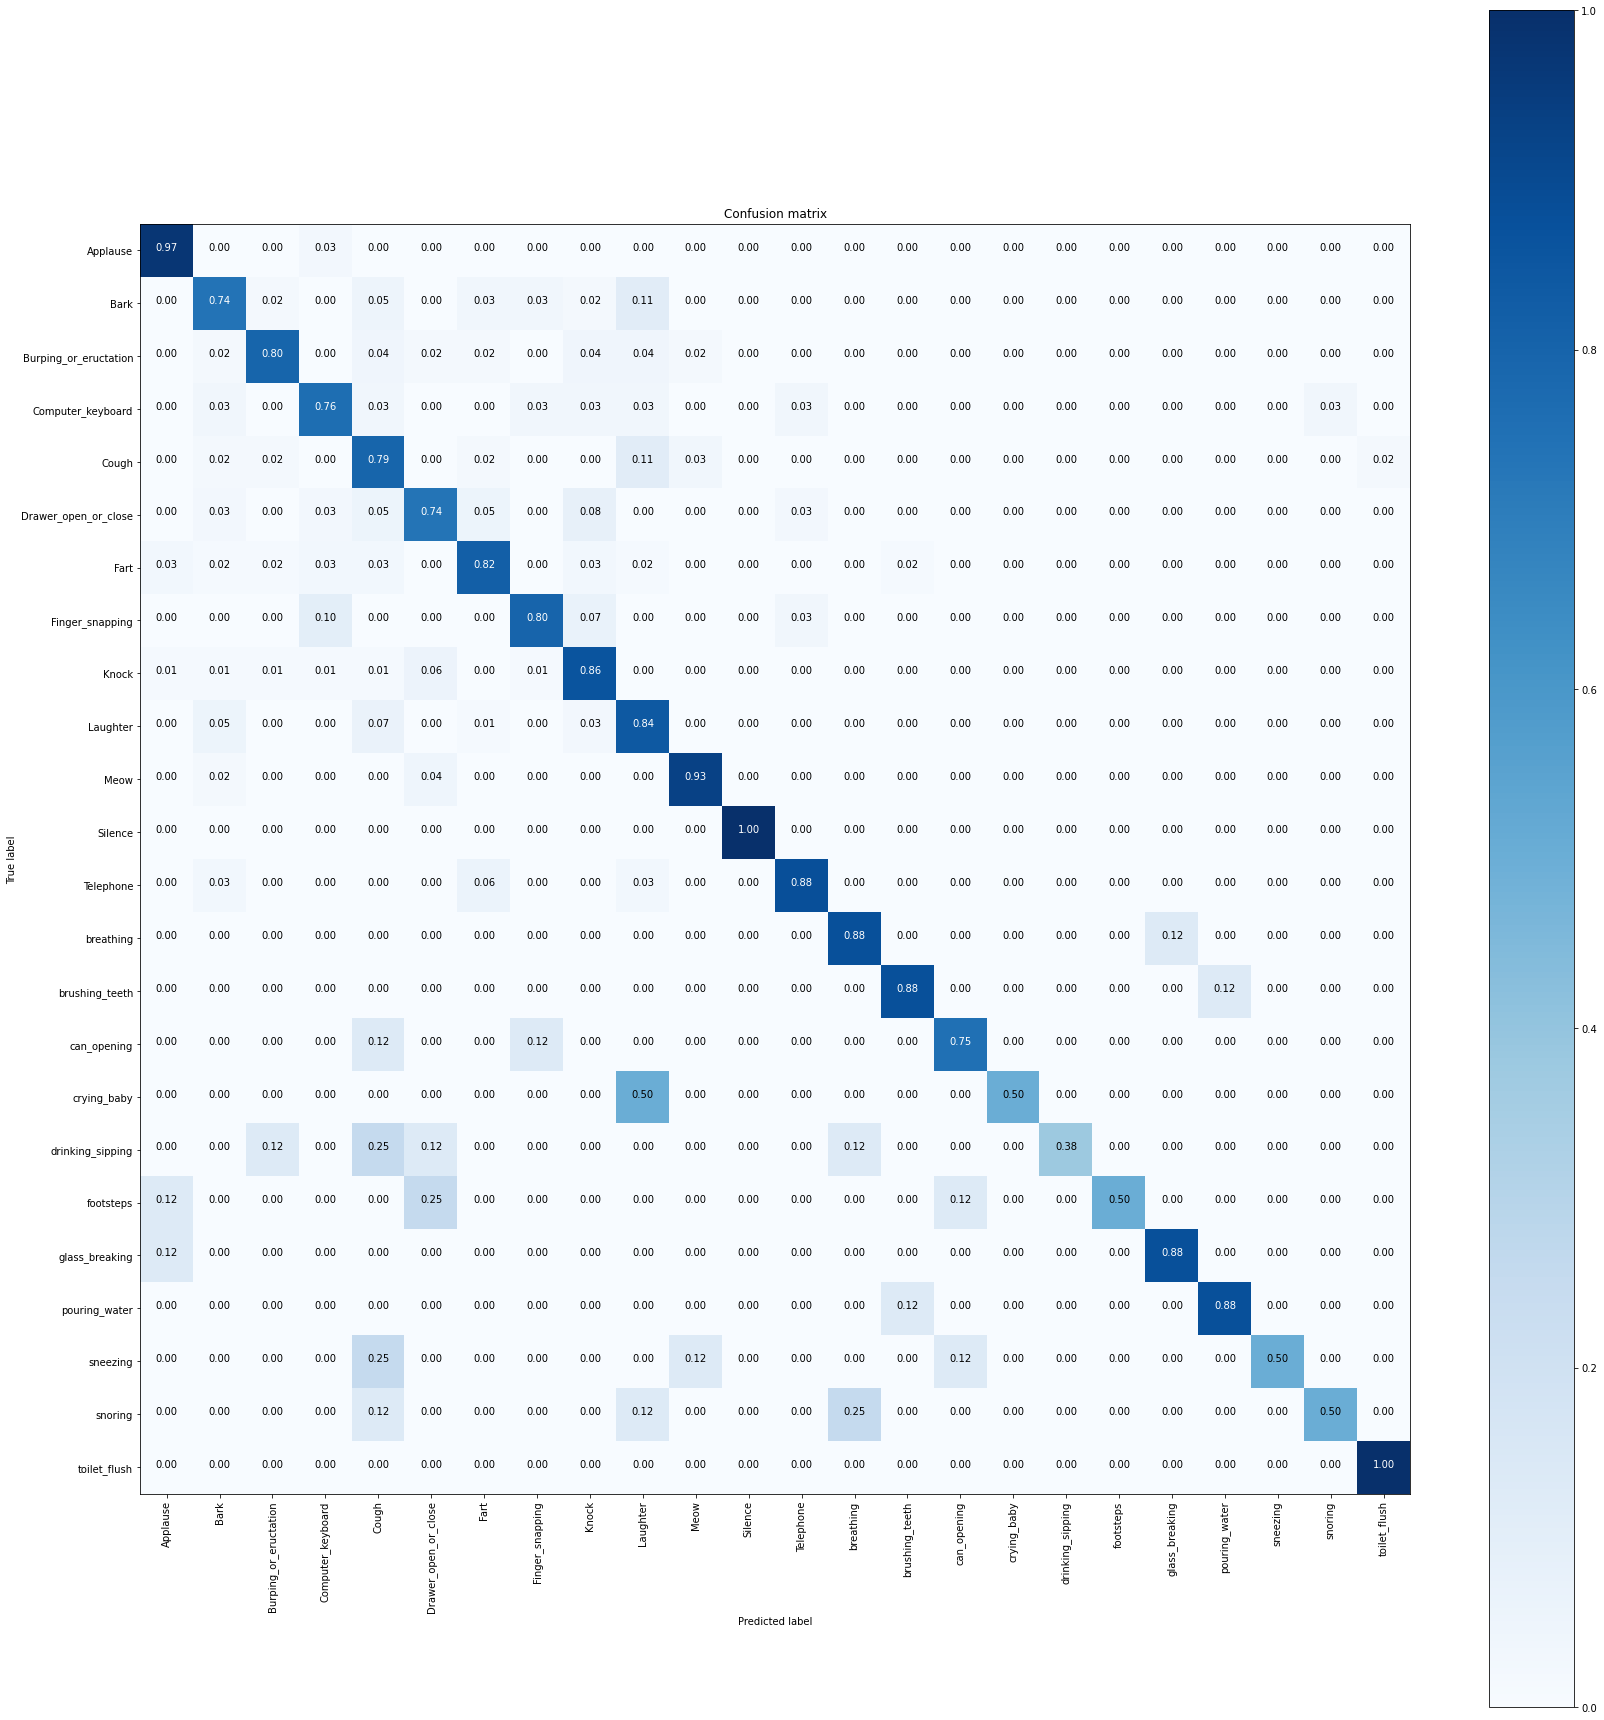

In [15]:
# Calculate and plot confusion matrix

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import os
from sklearn.metrics import confusion_matrix

testing_dir = '/content/drive/My Drive/ModeloKeras/DataProject 4/4.Audio/Dataset_Mix/melspectrograms/testing/'

y_true = []
y_pred = []
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        img_path = testing_dir + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)